<h1>Import Libraries<h1>

<h1> Titel: Machine Learning Projekt im Bereich Direct Mail Marketing <h1>

<h3>Deckblatt, Fußnoten mit Datum und Seitenzahlen, Einleitung mit Ziel des machine Learning Projekts, Vorgehen, methodische Unterstützung (Crisp-DM), Fazit: Was hat das Projekt gebracht und welche EMpfehlungen machen wir/ Reflexion (was würden wir anders machen wenn wir neu starten würden?), keine vielen Dank für Ihre Aufmerksamtkeit-Folie, Grundlagen gerne mit Formeln (z.B: Verlustfunktion formulieren)<h3>

<h2>Hauptkomponentenanalyse auf Pipeline<h2>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

<h1>Datensatz einlesen<h1>

In [3]:
path = r'./out/df_clean.csv'
df = pd.read_csv(path, sep=';', decimal=',')

<h1>Erläuterung der Datenspalten und Betrachtung einzelner Features<h1>

*   ZIP_CODE -> *Postleitzahl*
*   DAYS_SINCE_PURCHASE -> *Tage seit Kaufdatum*
*   PURCHASE_VISITS -> *Anzahl der Kaufbesuche*
*   TOTAL_NET_SALES -> *Gesamtnettoumsatz*
*   CC_CARD -> *Kreditkartenbenutzung*
*   AVE_AMOUNT_SPENT -> *Durchschnittlicher Betrag, der pro Besuch ausgegeben wird*
*   AMSPEND -> *im Franchise AM ausgegebener Betrag*
*   PSSPEND -> *im Franchise PS ausgegebener Betrag*
*   CCSPEND -> *im Franchise CC ausgegebener Betrag*
*   AXSPEND -> *im Franchise AX ausgegebener Betrag*
*   OMONSPEND -> *im letzten Monat ausgegebener Betrag*
*   TMONSPEND -> *in den letzten drei Monaten ausgegebener Betrag*
*   SMONSPEND -> *in den letzten sechs Monaten ausgegebener Betrag*
*   PREVPD -> *im gleichen Zeitraum des letzten Jahres ausgegebener Betrag*
*   GMP -> *Prozentsatz der Bruttomarge*
*   PROMOS -> *Anzahl der gespeicherten Marketingaktionen*
*   DAYS -> *Anzahl der Tage, in denen der Kunde registriert war*
*   FREDAYS -> *Anzahl der Tage zwischen den Käufen*
*   MARKDOWN -> *Abschlagsprozentsatz auf Kundenkäufe*
*   CLASSES -> *Anzahl der gekauften unterschiedlichen Produktklassen*
*   COUPONS -> *Anzahl der vom Kunden verwendeten Coupons*
*   STYLES -> *Gesamtzahl der vom Kunden gekauften Einzalartikel*
*   STORES -> *Anzahl der Geschäfte, in denen der Kunde eingekauft hat*
*   VALPHON -> *gültige Telefonnummer hinterlegt*
*   WEB -> *WEB-Shopper*
*   MAILED -> *Anzahl der im vergangenen Jahr verschickten Werbeaktionen*
*   RESPONDED -> *Anzahl der Werbeaktion, auf die im vergangenen Jahr reagiert wurde*
*   RESPONSERATE -> *Aktionsrücklauf für das vergangene Jahr*
*   HI -> *Produkteinheitlichkeit (niedriger Wert = unterschiedlicher Ausgabemuster)*
*   LTFREDAY -> *Lebenslage durchschnittliche Zeit zwischen Besuchen*
*   CLUSTYPE -> *Clusterzugehörigkeit*
*   PERCRET -> *Prozentsatz an Rückläufern*
*   RESP -> *Reaktion auf Promo*

In [4]:
am = df["AMSPEND"].sum()
ps = df["PSSPEND"].sum()
cc = df["CCSPEND"].sum()
ax = df["AXSPEND"].sum()
liste = [am,ps,cc,ax]

<h1>Funktion für den Train Test Validation Split<h1>

In [5]:
def split_train_test(df):
    random_state = 4711
    features = [x for x in df.columns if x!= "RESP"]
    X = df[features]
    y = df["RESP"]
    X_train, X_test_2, y_train, y_test_2 = train_test_split(X, y, test_size = 0.05, random_state=random_state)
    X_train, X_test_1, y_train, y_test_1 = train_test_split(X_train, y_train, test_size = 0.2, random_state=random_state)
    return X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1

In [6]:
def get_result(y_true, y_predicted):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    print("Y-true Typ: ", type(y_true))
    print("y_predicted Typ: ", type(y_predicted))

    y_true = y_true.to_list()
    y_predicted = y_predicted.tolist()

    print("y_true: ", y_true)
    print("y_predicted: ", y_predicted)

    for i in range(len(y_predicted)):
        if y_true[i]==y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_true[i]!=y_predicted[i]:
            FP += 1
        if y_true[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_true[i]!=y_predicted[i]:
            FN += 1

    print("TP: ",TP)
    print("FP: ",FP)
    print("TN: ",TN)
    print("FN: ",FN)


    return (TP*16+FP*(-2)+TN*(0)+FN*(-16))

<h1>Random Forest Classifier<h1>

**Hyperparameter Random Forest**

*   n_estimators = number of trees in the forest
*   max_features = max number of features considered for splitting a node
*   max_depth = max number of levels in each decision tree
*   min_samples_split = min number of data points placed in a node before the   node is split
*   min_sample_leaf = min number of data points allowed in a leaf node
*   bootstrap = method for sampling data points (with or without replacement)

**Best Hyperparameters so far:** n_estimators = 1200, min_samples_split = 10, min_samples_leaf = 4, max_features = "auto", max_depth = 50, bootstrap = True

**Hyperparameter Random Forest**

*   n_estimators = number of trees in the forest
*   max_features = max number of features considered for splitting a node
*   max_depth = max number of levels in each decision tree
*   min_samples_split = min number of data points placed in a node before the   node is split
*   min_sample_leaf = min number of data points allowed in a leaf node
*   bootstrap = method for sampling data points (with or without replacement)

<h2>Beispiel: Erster Random Forest Classifier mit einer maximalen Tiefe von 4<h2>

Accuracy:  84.72524812394093 %
Recall:  18.34733893557423 %
Precision:  73.18435754189943 %
F1 Score:  29.339305711086226 %


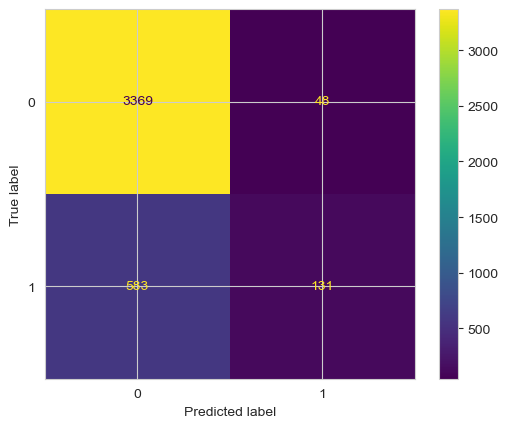

In [7]:
max_depth = 4
X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1 = split_train_test(df)
rf = RandomForestClassifier(max_depth=max_depth)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test_1)

accuracy = accuracy_score(y_test_1, y_predict)
precision = precision_score(y_test_1, y_predict)
recall = recall_score(y_test_1, y_predict)
f1score = f1_score(y_test_1, y_predict)

print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")
## Confusion Matrix
matrix = confusion_matrix(y_test_1,y_predict,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rf.classes_)
disp.plot()
plt.show()

<h2>Dabei von dem Random Forest Classifier genutzte Parameter<h2>

In [8]:
print("Parameters currently in use:\n")
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


<h2>Betrachtung der 10 Features, die bei diesem Random Forest Classifier am stärksten zur Klassifizierung beigetragen haben. Erstellen von Arrays mit Hyperparameterwerten, die für die GridSearch genutzt werden sollen<h2>

C:\Users\svenb\AppData\Local\Temp\ipykernel_10632\3536805271.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_important_features["RESP"] = df["RESP"]


{'max_depth': [5, 50, None], 'n_estimators': [100, 1000]}


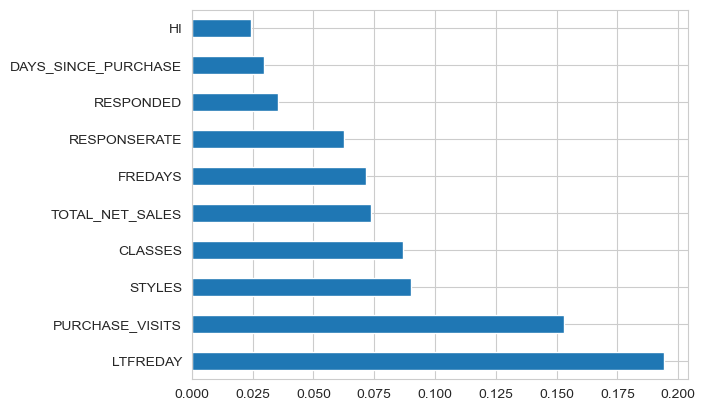

In [9]:
# top 10 features werden für das TRaining der kommenden Random Forest Classifier genutzt
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
important_features = feat_importances.nlargest(10).index


df_important_features = df[important_features]
df_important_features["RESP"] = df["RESP"]
X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1 = split_train_test(df_important_features)

# Hyperparameter werden für die GridSearch herausgesucht. Auskommentierte Zeilen können hinzugefügt werden:
# Allgemein gilt: Es müssen nicht extrem viele Werte und Hyperparameter durchlaufen werden, wichtig ist, dass der Sinn einer GridSearch verstanden wurde!

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=2)]
# Number of features to consider at every split
#max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
"""min_samples_split = [2,5,10]"""
# Minimum number of samples required at each leaf node
"""min_samples_leaf = [1,2,4]"""
# Method of selecting samples for training each tree
"""bootstrap = [True, False]"""

# Create the random grid
random_grid = {"n_estimators":n_estimators,
               #"max_features":max_features,
               "max_depth":max_depth}
#"min_samples_split":min_samples_split,
#"min_samples_leaf":min_samples_leaf,
#"bootstrap":bootstrap}
pprint(random_grid)

<h2>Funktion (Scorefunction) zur Berechnung des Gewinns/Verlustes gemäß der Aufgabenstellung (Gewinnmatrix)<h2>

In [10]:
def get_result_score(y_test, y_predicted):

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    y_true = y_test.to_list()
    y_predicted = y_predicted.tolist()

    for i in range(len(y_predicted)):
        if y_true[i]==y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_true[i]!=y_predicted[i]:
            FP += 1
        if y_true[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_true[i]!=y_predicted[i]:
            FN += 1


    return (TP*16+FP*(-2)+TN*(0)+FN*(-16))

<h2>Klassifizierung erneut anhand eines Random Forest Classifiers, diesmal mit vorangegangener GridSearch mit oben bestimmten Hyperparameter(werten) und Optimierung auf Grundlage der Ergebnisse der definierten individuellen Scorer Funktion<h2>

In [11]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Create new base model
rf = RandomForestClassifier(random_state = 4711)

"""#rf.fit(X_train, y_train)
#y_predict = rf.predict(X_test)"""

result_scorer = make_scorer(get_result_score)       #eigenen Scorer für GridSearch

# Random search for parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random_result_score = GridSearchCV(estimator = rf, param_grid = random_grid,
                                      cv = 3, verbose = 2,
                                      n_jobs = -1, scoring = result_scorer)

rf_random_result_accuracy = GridSearchCV(estimator = rf, param_grid = random_grid,
                                         cv = 3, verbose = 2,
                                         n_jobs = -1)
rf_random_result_recall = GridSearchCV(estimator = rf, param_grid = random_grid, 
                                       cv = 3, verbose = 2, 
                                       n_jobs = -1, scoring = "recall")

"""Andere Scorer Funktionen prüfen!!!"""

rf_random_result_score_res = rf_random_result_score.fit(X_train, y_train)
rf_random_result_accuracy_res = rf_random_result_accuracy.fit(X_train, y_train)
rf_random_result_recall_res = rf_random_result_recall.fit(X_train, y_train)

print("Best Score mit eigener Funktion: ",rf_random_result_score_res.best_score_)
print("Mit besten Parametern: ",rf_random_result_score_res.best_params_)
print("Best Score nach Accuracy: ",rf_random_result_accuracy_res.best_score_)
print("Mit besten Parametern: ",rf_random_result_accuracy_res.best_params_)
print("Best Score nach Recall: ",rf_random_result_recall_res.best_score_)
print("Mit besten Parametern: ",rf_random_result_recall_res.best_params_)
# Ausgabe des besten Scores (auf Grundlage der durchlaufenden Hyperparameter)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Score mit eigener Funktion:  -6267.333333333333
Mit besten Parametern:  {'max_depth': 50, 'n_estimators': 100}
Best Score nach Accuracy:  0.8560101672056035
Mit besten Parametern:  {'max_depth': 5, 'n_estimators': 1000}
Best Score nach Recall:  0.29592959295929594
Mit besten Parametern:  {'max_depth': 50, 'n_estimators': 100}


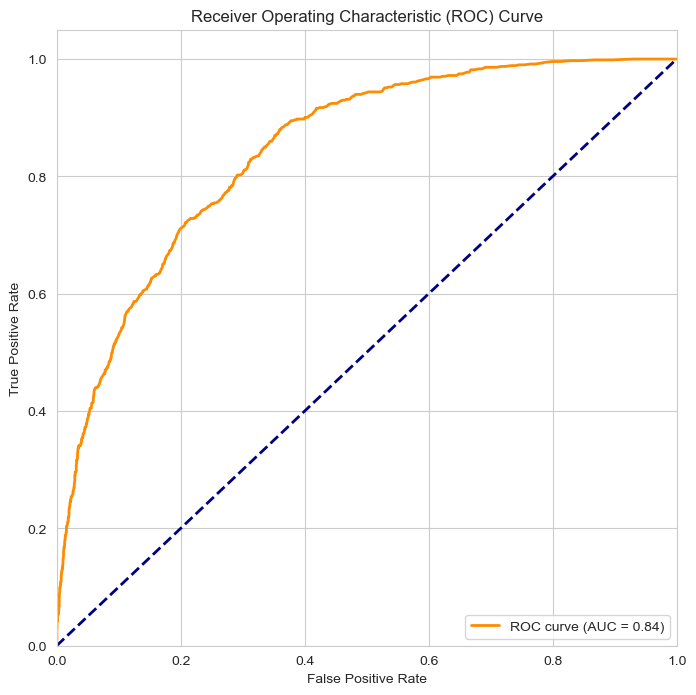

Accuracy:  85.42725732268217 %
Recall:  30.952380952380953 %
Precision:  66.96969696969697 %
F1 Score:  42.337164750957854 %
Score:  -4570


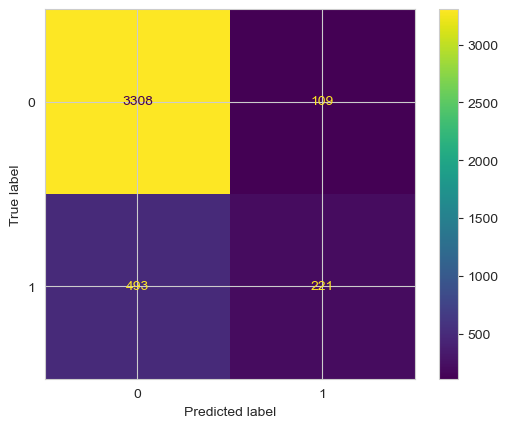

In [12]:
rf = RandomForestClassifier(random_state=4711, max_depth=50, n_estimators=1000)
rf.fit(X_train,y_train)
y_probabilities = rf.predict_proba(X_test_1)[:, 1]
y_predicted = rf.predict(X_test_1)

#Berechnen der ROC-Kurve und des AUC-Werts
fpr, tpr, thresholds = roc_curve(y_test_1, y_probabilities)
roc_auc = auc(fpr, tpr)

#Plot der ROC-Kurve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

accuracy = accuracy_score(y_test_1, y_predicted)
precision = precision_score(y_test_1, y_predicted)
recall = recall_score(y_test_1, y_predicted)
f1score = f1_score(y_test_1, y_predicted)
score = get_result_score(y_test_1, y_predicted)

print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")
print("Score: ", score)
matrix = confusion_matrix(y_test_1,y_predicted,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rf.classes_)
disp.plot()
plt.show()

<h2>Threshold Tuning<h2>

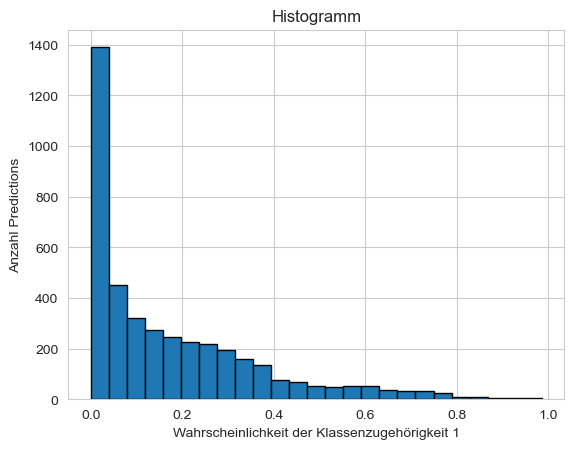

Threshold=0.076, Score-Wert=6754.00000


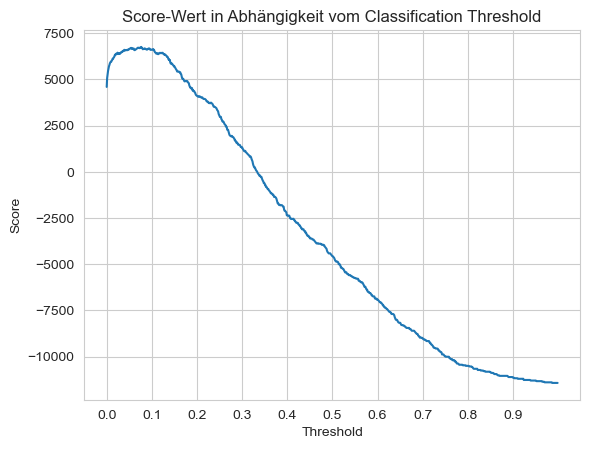

In [13]:
def to_labels(probabilities, threshold):
    return(probabilities >= threshold).astype("int")

rf = RandomForestClassifier(random_state=4711, max_depth=50, n_estimators=1000)


#Thresholds evaluieren
rf.fit(X_train,y_train)
yhat = rf.predict_proba(X_test_1)
probs = yhat[:,1]
plt.hist(probs, bins=25, edgecolor='black')
plt.xlabel('Wahrscheinlichkeit der Klassenzugehörigkeit 1')
plt.ylabel('Anzahl Predictions')
plt.title('Histogramm')
plt.show()

thresholds = np.arange(0,1,0.001)
scores = [get_result_score(y_test_1,to_labels(probs,t)) for t in thresholds]
ix = np.argmax(scores)
print("Threshold=%.3f, Score-Wert=%.5f"%(thresholds[ix],scores[ix]))
plt.plot(np.arange(0,1,0.001), scores)
plt.xticks(np.arange(0,1,0.1))
plt.title("Score-Wert in Abhängigkeit vom Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel('Score')
plt.show()

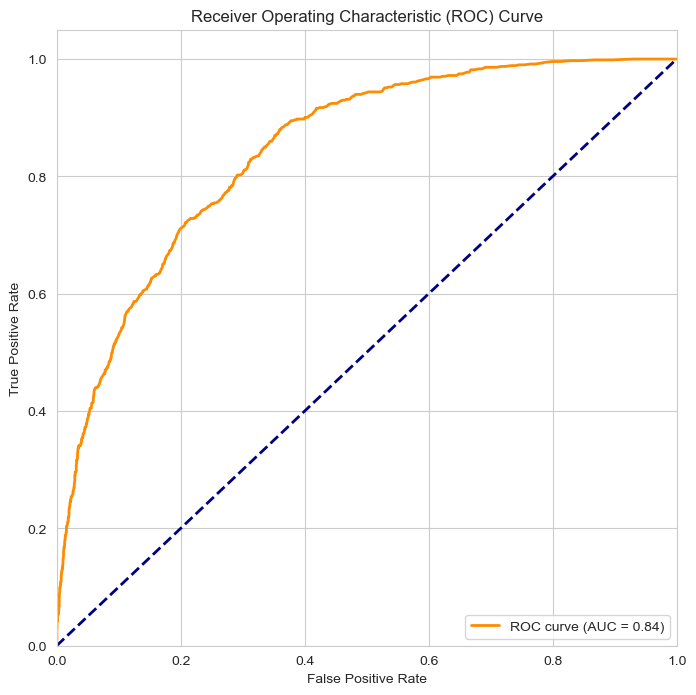

Accuracy:  59.70561177552898 %
Recall:  90.58823529411765 %
Precision:  26.73611111111111 %
F1 Score:  41.28686327077748 %
Score:  1364


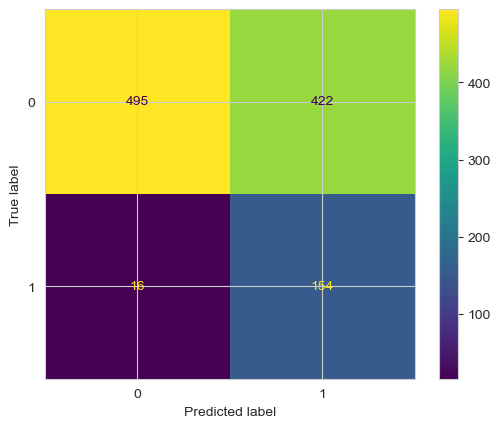

In [14]:
rf = RandomForestClassifier(random_state=4711, max_depth=50, n_estimators=1000)
rf.fit(X_train,y_train)

y_probabilities = rf.predict_proba(X_test_1)[:, 1]
y_predicted = rf.predict(X_test_1)

#Berechnen der ROC-Kurve und des AUC-Werts
fpr, tpr, thresholds = roc_curve(y_test_1, y_probabilities)
roc_auc = auc(fpr, tpr)

#Plot der ROC-Kurve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

y_predicted = (rf.predict_proba(X_test_2)[:,1]>=0.085).astype(bool)
accuracy = accuracy_score(y_test_2, y_predicted)
precision = precision_score(y_test_2, y_predicted)
recall = recall_score(y_test_2, y_predicted)
f1score = f1_score(y_test_2, y_predicted)
score = get_result_score(y_test_2, y_predicted)

print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")
print("Score: ", score)
matrix = confusion_matrix(y_test_2,y_predicted,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rf.classes_)
disp.plot()
plt.show()